In [38]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import numpy as np
import pickle
import torch
from torch import nn
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn import model_selection

import sys
import os
current_dir = os.path.dirname(os.path.abspath('__file__'))
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)
from dataHandler.preprocessor import Preprocessor

print(torch.__version__)

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

2.3.0+cu121
Using cpu device


In [39]:
#from google.colab import drive
#drive.mount('/content/drive')

__Getting data__

In [40]:
directory = "/home/michal/Desktop/UniversityOfEssex/MasterProject/22-24_CE901-CE911-CF981-SU_kaczmarczyk_michal_p/data/Bloomberg/"
files = os.listdir(directory)
files = [f for f in files if os.path.isfile(directory+'/'+f)]
files
files = ["RR.L.csv"]

In [41]:
dataDir = "/home/michal/Desktop/UniversityOfEssex/MasterProject/22-24_CE901-CE911-CF981-SU_kaczmarczyk_michal_p/data/data/"
dataset = []
for file in files:
    df = pd.read_csv(dataDir + file).set_index("Date")
    columns = df.columns
    df = df[columns[0:6]]
    print(df)
    df.index = pd.to_datetime(df.index)
    bl = pd.read_csv(directory + file).set_index("Date")
    bl.index = pd.to_datetime(bl.index)
    bl = bl["Price Earnings Ratio \n(P/E) \n(RR/ LN Equity)"]
    bl = bl.resample('D')
    bl = bl.ffill()
    bl = bl.bfill()
    df = df.join(bl, how="inner")
    dataset.append(df)

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2014-06-27  361.699188  368.659393  361.012909  366.846710  335.903229   
2014-06-30  367.876312  368.905792  361.012909  366.846710  335.903229   
2014-07-01  366.503601  368.689606  363.415100  367.189911  336.217499   
2014-07-02  368.905792  370.964813  358.610687  359.640198  329.304626   
2014-07-03  359.983398  367.189911  359.022491  364.787689  334.017853   
...                ...         ...         ...         ...         ...   
2024-05-20  418.399994  437.899994  417.700012  436.799988  436.799988   
2024-05-21  435.700012  439.500000  431.000000  433.000000  433.000000   
2024-05-22  431.700012  439.799988  424.399994  428.000000  428.000000   
2024-05-23  429.000000  446.700012  419.799988  440.399994  440.399994   
2024-05-24  437.000000  445.299988  435.290009  444.799988  444.799988   

               Volume  
Date         

In [42]:
trainDataset = []
testDataset = []
preprocessor = Preprocessor()
i=0
for df in dataset:
    df.insert(0, "Date", df.index)
    df = preprocessor.leaveDataSinceDate(df)
    #if files[i] == "RR.L.csv":
    train, test = model_selection.train_test_split(df, test_size=0.2, shuffle=False)
    trainDataset.append(train)
    testDataset.append(test)
    #else:
    #    trainDataset.append(df)
    i+=1

In [43]:
preprocessor = Preprocessor()
for i in range(len(trainDataset)):
    trainDataset[i] = preprocessor.dropUnnamedColumn(trainDataset[i])
    trainDataset[i] = preprocessor.dropDuplicates(trainDataset[i])
    trainDataset[i] = preprocessor.addChangeFeature(trainDataset[i])
    columns = trainDataset[i].columns
    trainDataset[i][columns[1:]] = preprocessor.fillMissingData(trainDataset[i][columns[1:]])
    trainDataset[i][columns[1:]] = preprocessor.scaleData(trainDataset[i][columns[1:]])
    trainDataset[i] = preprocessor.sortValuesByDate(trainDataset[i])
    trainDataset[i].set_index("Date", inplace = True)

In [44]:
preprocessor = Preprocessor()
for i in range(len(testDataset)):
    testDataset[i] = preprocessor.dropUnnamedColumn(testDataset[i])
    testDataset[i] = preprocessor.dropDuplicates(testDataset[i])
    testDataset[i] = preprocessor.addChangeFeature(testDataset[i])
    columns = testDataset[i].columns
    testDataset[i][columns[1:]] = preprocessor.fillMissingData(testDataset[i][columns[1:]])
    testDataset[i][columns[1:]] = preprocessor.scaleData(testDataset[i][columns[1:]])
    testDataset[i] = preprocessor.sortValuesByDate(testDataset[i])
    testDataset[i].set_index("Date", inplace = True)

preprocessor.saveScalers()

__Date Embedding and cyclical transformation__

In [45]:

def getDateRange(start_date, end_date):
    current_date = start_date
    dates = []
    while current_date <= end_date:
        dates.append(current_date.strftime('%Y-%m-%d'))
        current_date += timedelta(days=1)
    return dates

# Define the date range
start_date = datetime(2024, 5, 24) - timedelta(days=40*365)  # 40 years ago
end_date = datetime(2024, 5, 24) + timedelta(days=40*365)    # 40 years in the future

# Generate the list of dates
dictionary = getDateRange(start_date, end_date)
date_to_index = {date: index for index, date in enumerate(dictionary)}

class DateEmbeddingModel(nn.Module):
    def __init__(self, num_embeddings = 29201, embedding_dim = 8):
        super(DateEmbeddingModel, self).__init__()
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)

    def forward(self, dates):
        date_indices = torch.tensor([date_to_index[date] for date in dates], dtype=torch.long)
        embedded_dates = self.embedding(date_indices)
        return embedded_dates

In [46]:
def dateCyclicalTransformation(date):
    date = pd.to_datetime(date)

    monthSin = np.sin(2 * np.pi * date.month/12.0)
    monthCos = np.cos(2 * np.pi * date.month/12.0)
    daySin = np.sin(2 * np.pi * date.day/31.0)
    dayCos = np.cos(2 * np.pi * date.day/31.0)

    return [monthSin, monthCos, daySin, dayCos]

__Creating data loader__

In [47]:
def createSequence(dataX, dataY, lengthX, predictionHorizont):
    xData = []
    yData = []
    for i in range(len(dataX) - lengthX - predictionHorizont):
        xData.append(dataX[i:i+lengthX].values)
        yData.append(dataY[(lengthX + i):(lengthX + predictionHorizont + i)].values)
    return xData, yData

features = len(trainDataset[0].iloc[0])
samplesForPrediction = 15
samplesPredicted = 5

trainDates = trainDataset[0].index[samplesForPrediction+1:]
testDates = testDataset[0].index[samplesForPrediction+1:]
xTrain = []
yTrain = []
xTest = []
yTest = []
for df in trainDataset:
    trainX, trainY = createSequence(df, df["Close"], samplesForPrediction, samplesPredicted)
    xTrain += trainX
    yTrain += trainY
for df in testDataset:
    testX, testY = createSequence(df, df["Close"], samplesForPrediction, samplesPredicted)
    xTest += testX
    yTest += testY

In [48]:
xTrain = torch.Tensor(xTrain).to(device)
yTrain = torch.Tensor(yTrain).to(device)
xTest = torch.Tensor(xTest).to(device)
yTest = torch.Tensor(yTest).to(device)

__Model__

In [49]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.l1 = nn.LSTM(input_size = samplesForPrediction*features, hidden_size = 128, num_layers = 3, bidirectional = False, device = device, bias=True)
        self.tanh = nn.Tanh()
        self.out = nn.Linear(128, samplesPredicted, device = device, bias=True)

    def forward(self, x):
        x = self.flatten(x)
        x, _ = self.l1(x)
        x = self.tanh(x)
        out = self.out(x)
        return out

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (l1): LSTM(120, 128, num_layers=3)
  (tanh): Tanh()
  (out): Linear(in_features=128, out_features=5, bias=True)
)


In [50]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(xTrain, yTrain), shuffle=False, batch_size=4)

In [51]:
train_loss = []
test_loss = []

In [52]:
def trainLoop(epochs):
    for epoch in range(epochs):
        model.train()
        for inputData, desired in loader:
            inputData = inputData.to(device)
            desired = desired.to(device)
            pred = model(inputData)
            loss = loss_fn(pred, desired)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        model.eval()
        with torch.no_grad():
            y_pred = model(xTrain.to(device))
            train_loss.append(loss_fn(y_pred, yTrain).cpu().numpy().tolist())
            y_pred = model(xTest.to(device))
            test_loss.append(loss_fn(y_pred, yTest).cpu().numpy().tolist())
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss[-1:]}, Test Loss: {test_loss[-1:]}')
    return train_loss, test_loss


#model = torch.load('/content/drive/MyDrive/MasterProject/lstm/model.pth')
train_loss, test_loss = trainLoop(110)
torch.save(model, '../models/lstm5Days.pth')


Epoch [1/110], Train Loss: [0.20065681636333466], Test Loss: [0.25562018156051636]
Epoch [2/110], Train Loss: [0.06936772167682648], Test Loss: [0.041569460183382034]
Epoch [3/110], Train Loss: [0.10969240963459015], Test Loss: [0.05468853935599327]
Epoch [4/110], Train Loss: [0.07685638219118118], Test Loss: [0.040710195899009705]
Epoch [5/110], Train Loss: [0.0428224615752697], Test Loss: [0.0254009161144495]
Epoch [6/110], Train Loss: [0.027088385075330734], Test Loss: [0.017736779525876045]
Epoch [7/110], Train Loss: [0.020741403102874756], Test Loss: [0.014380158856511116]
Epoch [8/110], Train Loss: [0.017581453546881676], Test Loss: [0.012626619078218937]
Epoch [9/110], Train Loss: [0.015692558139562607], Test Loss: [0.01158747635781765]
Epoch [10/110], Train Loss: [0.014440320432186127], Test Loss: [0.010934259742498398]
Epoch [11/110], Train Loss: [0.013543625362217426], Test Loss: [0.010500390082597733]
Epoch [12/110], Train Loss: [0.012857598252594471], Test Loss: [0.01019114

In [53]:
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save('../models/lstm.pt') # Save


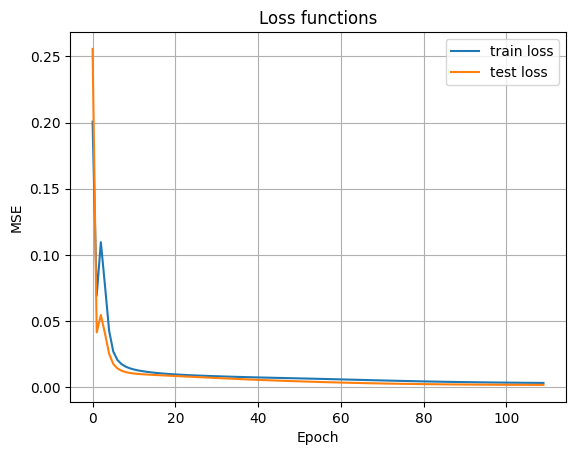

In [54]:
fig, ax = plt.subplots()
ax.plot(train_loss)
ax.plot(test_loss)
ax.legend(["train loss", "test loss"])
ax.grid()
plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.title("Loss functions")
plt.show()

__Testing__

Total Mean Squared Error: 0.0034046124201267958
Total Mean Absolute Error: 0.04866034537553787
Total Root Mean Squared Error: 0.05801766365766525


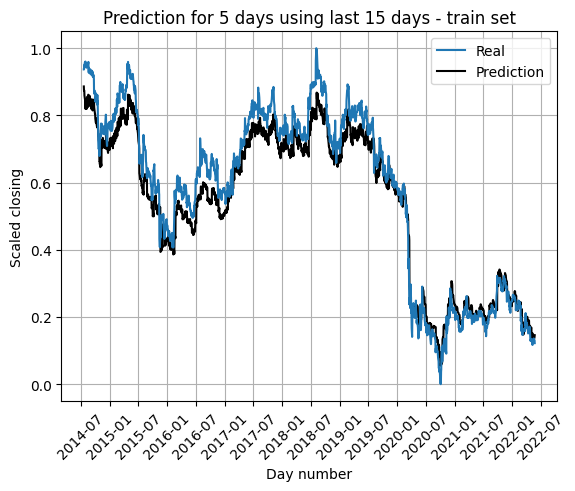

In [55]:
# Make predictions
y_pred = model(xTrain).cpu()

y_pred = y_pred.detach().numpy()


# Calculate the mean squared error across all outputs
mse_total = mean_squared_error(yTrain.cpu().detach().numpy(), y_pred)
mae_total = mean_absolute_error(yTrain.cpu().detach().numpy(), y_pred)
rmse_total = mean_squared_error(yTrain.cpu().detach().numpy(), y_pred, squared=False)
print(f'Total Mean Squared Error: {mse_total}')
print(f'Total Mean Absolute Error: {mae_total}')
print(f'Total Root Mean Squared Error: {rmse_total}')

set = 5*2
real = np.concatenate(yTrain.cpu().detach().numpy()[::samplesPredicted])
predictions = np.concatenate(y_pred[::samplesPredicted])

fig, ax = plt.subplots()
#ax.plot(trainDates, real, zorder = 3)
#ax.plot(trainDates, predictions, color = 'black', zorder = 2)
ax.plot(trainDates[:1985], real, zorder = 3)
ax.plot(trainDates[:1985], predictions, color = 'black', zorder = 2)

# Rotate date labels for better readability
plt.xticks(rotation=45)

# Optionally, set the locator to have fewer ticks
locator = plt.matplotlib.dates.AutoDateLocator(minticks=10, maxticks=20)
ax.xaxis.set_major_locator(locator)


ax.legend(["Real", "Prediction"])
#ax.axvspan(0, 4, facecolor='lightblue', alpha=0.5, zorder = 1)  # First part
#ax.axvspan(4, 9, facecolor='lightgreen', alpha=0.5, zorder = 1)  # Second part
#ax.axvspan(9, 14, facecolor='tomato', alpha=0.5, zorder = 1)  # Second third
#ax.set_ylim([0, 1])
ax.grid()
plt.ylabel("Scaled closing")
plt.xlabel("Day number")
plt.title("Prediction for 5 days using last 15 days - train set")
plt.show()



Total Mean Squared Error: 0.0018899316200986505
Total Mean Absolute Error: 0.029336586594581604
Total Mean Absolute Percentage Error: 0.042650915682315826


/tmp/ipykernel_23333/1533856344.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dummyDataset["Close"] = predictions
/tmp/ipykernel_23333/1533856344.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dummyDataset["Close"] = real


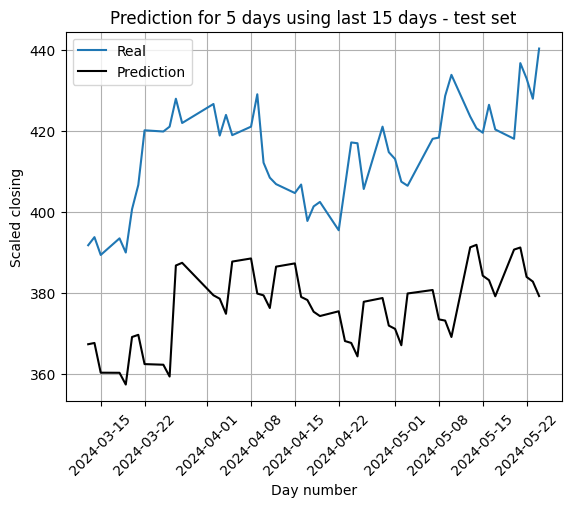

In [56]:
# Make predictions
y_pred = model(xTest).cpu()

y_pred = y_pred.detach().numpy()

# Calculate the mean squared error across all outputs
mse_total = mean_squared_error(yTest.cpu().detach().numpy(), y_pred)
mae_total = mean_absolute_error(yTest.cpu().detach().numpy(), y_pred)
rmse_total = mean_squared_error(yTest.cpu().detach().numpy(), y_pred, squared=False)
print(f'Total Mean Squared Error: {mse_total}')
print(f'Total Mean Absolute Error: {mae_total}')
print(f'Total Mean Absolute Percentage Error: {rmse_total}')

set = 5*2
real = np.concatenate(yTest.cpu().detach().numpy()[::samplesPredicted])
predictions = np.concatenate(y_pred[::samplesPredicted])

#Rescaling
dummyDataset = testDataset[0].tail(len(predictions))
dummyDataset["Close"] = predictions
dummyDataset = preprocessor.scaler.inverse_transform(dummyDataset)
predictions = dummyDataset[:,3]

dummyDataset = testDataset[0].tail(len(real))
dummyDataset["Close"] = real
dummyDataset = preprocessor.scaler.inverse_transform(dummyDataset)
real = dummyDataset[:,3]

fig, ax = plt.subplots()
ax.plot(np.array(testDates)[-50:], real[-50:], zorder = 3)
ax.plot(np.array(testDates)[-50:], predictions[-50:], color = 'black', zorder = 2)

# Rotate date labels for better readability
plt.xticks(rotation=45)

# Optionally, set the locator to have fewer ticks
locator = plt.matplotlib.dates.AutoDateLocator(minticks=10, maxticks=20)
ax.xaxis.set_major_locator(locator)

ax.legend(["Real", "Prediction"])
#ax.axvspan(0, 4, facecolor='lightblue', alpha=0.5, zorder = 1)  # First part
#ax.axvspan(4, 9, facecolor='lightgreen', alpha=0.5, zorder = 1)  # Second part
#ax.axvspan(9, 14, facecolor='tomato', alpha=0.5, zorder = 1)  # Second third
#ax.set_ylim([0, 1])
ax.grid()
plt.ylabel("Scaled closing")
plt.xlabel("Day number")
plt.title("Prediction for 5 days using last 15 days - test set")
plt.show()



In [57]:
profit = 0
lastBuy = 0
action = []
#for realVal, predVal in zip(real[:-samplesPredicted], predictions[samplesPredicted::samplesPredicted]):
for realVal, predVal in zip(real, predictions):
    if(realVal<predVal and lastBuy == 0):
        lastBuy = realVal
        action.append(1)
    elif(realVal > predVal and lastBuy > 0):
        profit += realVal - lastBuy
        lastBuy = 0
        action.append(-1)
    else:
        action.append(0)

if(lastBuy>0):
    profit += realVal - lastBuy
    lastBuy = 0
    action.append(-1)
else:
    action.append(0)

print(profit)

119.41005973885864


In [58]:
action = action[:485]

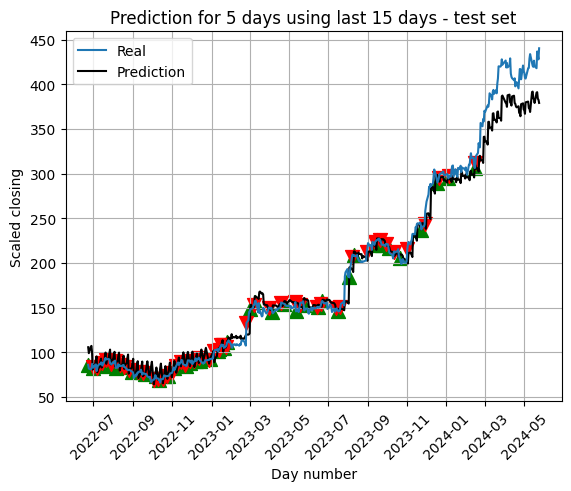

In [59]:
real = real[:]
predictions = predictions[:]
testDates = testDates[:]
action = np.array(action[:])

buy_dates = np.array(testDates)[action == 1]
sell_dates = np.array(testDates)[action == -1]

buy_prices = real[action == 1]
sell_prices = real[action == -1]

fig, ax = plt.subplots()
ax.plot(np.array(testDates), real, zorder = 3)
ax.plot(np.array(testDates), predictions, color = 'black', zorder = 2)

ax.scatter(buy_dates, buy_prices, color='green', marker='^', s=100, label='Buy')
ax.scatter(sell_dates, sell_prices, color='red', marker='v', s=100, label='Sell')

# Rotate date labels for better readability
plt.xticks(rotation=45)

# Optionally, set the locator to have fewer ticks
locator = plt.matplotlib.dates.AutoDateLocator(minticks=10, maxticks=20)
ax.xaxis.set_major_locator(locator)

ax.legend(["Real", "Prediction"])
ax.grid()
plt.ylabel("Scaled closing")
plt.xlabel("Day number")
plt.title("Prediction for 5 days using last 15 days - test set")
plt.show()

